## 1.Loading the Required Libraries

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

In [259]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score

In [260]:
from warnings import filterwarnings
filterwarnings('ignore')

## 2.Loading the Dataset

In [261]:
df_insurance=pd.read_csv('C:/Users/Sushree Jena/Desktop/imarticus/machine learning/Kaggle/insurance/insurance.csv')

In [262]:
df_insurance.shape

(1338, 7)

In [263]:
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3.Exploratory Data Analysis

In [264]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Checking for Missing Values

In [265]:
df_insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [266]:
df_insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Feature Engineering

In [268]:
df_insurance['age_cat']=pd.cut(df_insurance.age,bins=[15,30,45,61],labels=['young','middle','old'])

In [269]:
df_insurance['category']=['single' if x==0 else 'family' for x in df_insurance['children']]

In [270]:
#df_insurance['bmi_status']=pd.cut(df_insurance.bmi,bins=[0,19,25,30,60],labels=['underweight','healthy','overweight','obese'])

In [271]:
#Dropping the extra columns since we donnot require it for model building

In [272]:
df_insurance=df_insurance.drop(['age','children'],axis=1)

In [273]:
df_insurance.head()

,sex,bmi,smoker,region,charges,age_cat,category
0,female,27.900,yes,southwest,16884.92400,young,single
1,male,33.770,no,southeast,1725.55230,young,family
2,male,33.000,no,southeast,4449.46200,young,family
3,male,22.705,no,northwest,21984.47061,middle,single
4,male,28.880,no,northwest,3866.85520,middle,single


### Checking for outliers

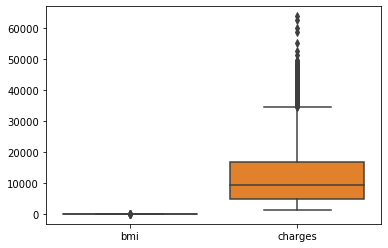

In [275]:
sns.boxplot(data=df_insurance)
plt.show()

We can see that there are outliers present in charges column.So we need to treat it.

In [276]:
#Treating the outliers

In [277]:
def boundaries(data,variable):
    LL=(data[variable].quantile(.25))-(((data[variable].quantile(.75))-(data[variable].quantile(.25)))*1.5)
    UL=(data[variable].quantile(.75))+(((data[variable].quantile(.75))-(data[variable].quantile(.25)))*1.5)
    return LL,UL

In [278]:
cols=['bmi','charges']

In [279]:
for col in cols:
    LL,UL=boundaries(df_insurance,col)
    
    df_insurance[col]=np.where(df_insurance[col]<LL,LL,
                            np.where(df_insurance[col]>UL,UL,df_insurance[col]))

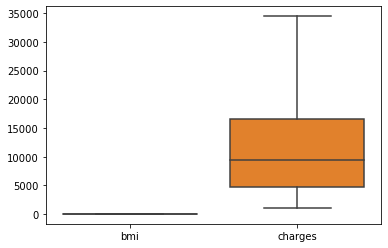

In [280]:
sns.boxplot(data=df_insurance)
plt.show()

We can see that the outliers have been trated now.

In [281]:
df_insurance

,sex,bmi,smoker,region,charges,age_cat,category
0,female,27.900,yes,southwest,16884.92400,young,single
1,male,33.770,no,southeast,1725.55230,young,family
2,male,33.000,no,southeast,4449.46200,young,family
3,male,22.705,no,northwest,21984.47061,middle,single
4,male,28.880,no,northwest,3866.85520,middle,single
...,...,...,...,...,...,...,...
1333,male,30.970,no,northwest,10600.54830,old,family
1334,female,31.920,no,northeast,2205.98080,young,single
1335,female,36.850,no,southeast,1629.83350,young,single
1336,female,25.800,no,southwest,2007.94500,young,single


### Test for Correlation

In [286]:
vcorr=df_insurance.corr()

In [287]:
vcorr

,bmi,charges
bmi,1.000000,0.160996
charges,0.160996,1.000000


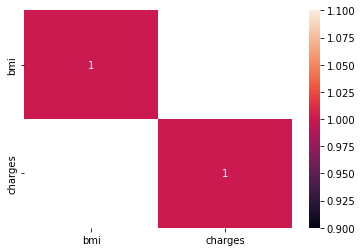

In [288]:
sns.heatmap(vcorr[(vcorr>0.85) | (vcorr<-0.85)],annot=True)
plt.show()

We can find that there is no strong correlation.

### Test for normality

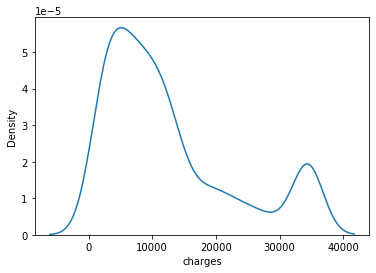

In [290]:
sns.kdeplot(x='charges',data=df_insurance)
plt.show()

In [291]:
df_insurance.charges.skew()

1.0837301093573644

In [292]:
df_insurance['log_charges']=np.log(df_insurance['charges'])

In [293]:
#Checking for the log charges column
df_insurance.head()

,sex,bmi,smoker,region,charges,age_cat,category,log_charges
0,female,27.900,yes,southwest,16884.92400,young,single,9.734176
1,male,33.770,no,southeast,1725.55230,young,family,7.453302
2,male,33.000,no,southeast,4449.46200,young,family,8.400538
3,male,22.705,no,northwest,21984.47061,middle,single,9.998092
4,male,28.880,no,northwest,3866.85520,middle,single,8.260197


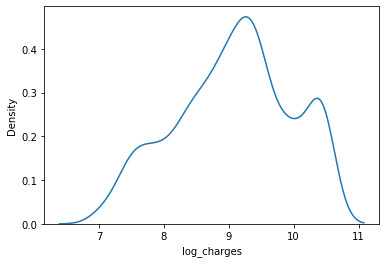

In [294]:
sns.kdeplot(x='log_charges',data=df_insurance)
plt.show()

In [295]:
df_insurance.log_charges.skew()

-0.22369223793730086

### Creating a backup file

In [297]:
df_insurance1=df_insurance.copy(deep=True)

## 4.Dummy encoding of categorical Variables

In [299]:
df_insurance1_dummy=pd.get_dummies(df_insurance1,drop_first=True)

In [300]:
df_insurance1_dummy.shape

(1338, 11)

In [301]:
df_insurance1_dummy.head()

,bmi,charges,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_cat_old,age_cat_young,category_single
0,27.900,16884.92400,9.734176,0,1,0,0,1,0,1,1
1,33.770,1725.55230,7.453302,1,0,0,1,0,0,1,0
2,33.000,4449.46200,8.400538,1,0,0,1,0,0,1,0
3,22.705,21984.47061,9.998092,1,0,1,0,0,0,0,1
4,28.880,3866.85520,8.260197,1,0,1,0,0,0,0,1


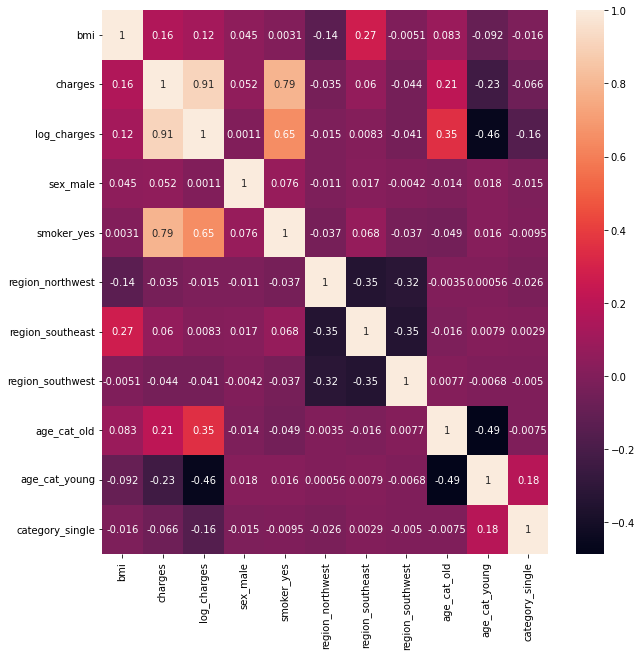

In [302]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_insurance1_dummy.corr(),annot=True)
plt.show()

## 5.Visualisations

In [308]:
#Counting the males and females

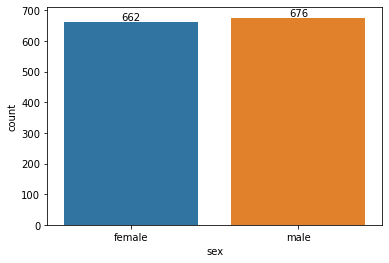

In [310]:
cp=sns.countplot(df_insurance['sex'])
cp.bar_label(cp.containers[0])
plt.show()

There are 662 females and 676 males in total.

In [311]:
#Plotting age_cat and charges distribution

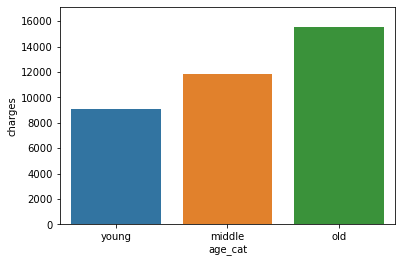

In [314]:
sns.barplot(x='age_cat',y='charges',data=df_insurance,errwidth=0)
plt.show()

We can find that the medical charges as well as insurance cost increases with increase in age.

In [306]:
#finding out how many single person and family were covered with insurance

In [315]:
df_insurance.category.value_counts()

family    764
single    574
Name: category, dtype: int64

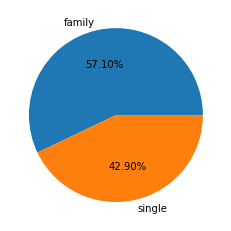

In [316]:
keys=['family','single']

plt.pie(df_insurance['category'].value_counts(),labels=keys,autopct='%.2f%%')
plt.show()

As per the pie chart, 57.10% of the total individuals had insurance for their family, whereas 42.90% had it for themselves.

In [317]:
#Finding the relation between category and charges

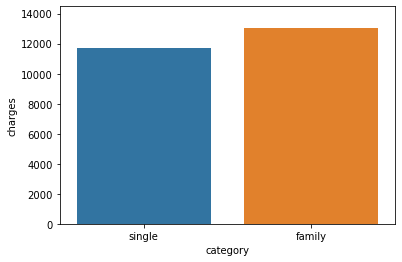

In [318]:
sns.barplot(x='category',y='charges',data=df_insurance,errwidth=0)
plt.show()

According to the plot, the insurance charges for entire family is more as compared to insurance charges for individual.

In [319]:
#Finding out how charges vary depending on sex of the person and his/her smoking behaviour

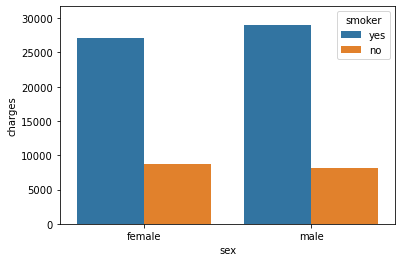

In [321]:
sns.barplot(x='sex',y='charges',hue='smoker',data=df_insurance,errwidth=0)
plt.show()

As per the graph, males pay a greater amount towards insurance as compared to females. We can also see clearly that insurance costs are very high if the person is a smoker.

In [326]:
#region wise distribution

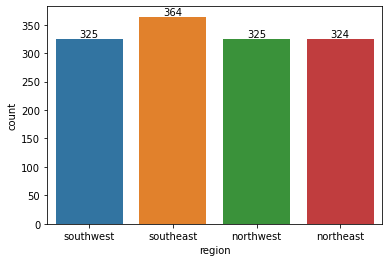

In [329]:
cp=sns.countplot(df_insurance['region'])
cp.bar_label(cp.containers[0])
plt.show()

The highest observation is from southeast region.

In [330]:
#Finding out how charges vary depending on region of the person and his/her smoking behaviour

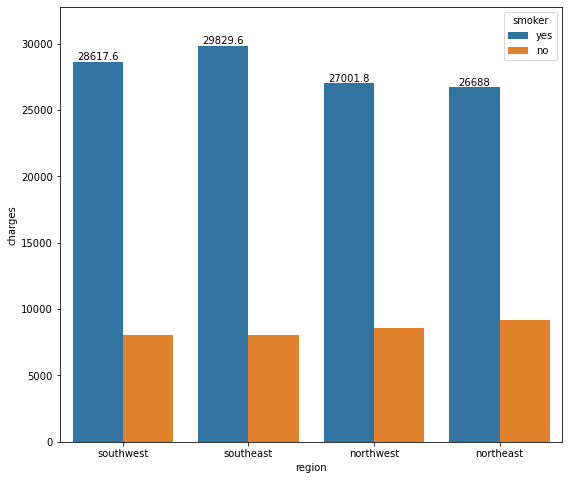

In [334]:
plt.figure(figsize=(9,8))
bp=sns.barplot(x='region',y='charges',hue='smoker',data=df_insurance,errwidth=0)
bp.bar_label(bp.containers[0])
plt.show()

We can find that in all regions, the smokers are much more as compared to non-smokers.

## 6.Separating the dependent and independent features

In [158]:
X=df_insurance1_dummy.drop(['charges','log_charges'],axis=1)
y=df_insurance1_dummy[['charges','log_charges']]

## 7.Splitting the data into train and test data set

In [160]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [161]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1070, 9), (268, 9), (1070, 2), (268, 2))

## 8.Scaling the data

In [163]:
sc=StandardScaler()

In [164]:
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)

## 9.Finding best parmeters

In [179]:
#GridSearch CV

In [180]:
#gridsearchCV using RandomForest model(with Charges column)

In [181]:
tuned_parameters={'n_estimators':[85,100],'min_samples_split':[15,20],'max_depth':[8,10]}

In [182]:
gs_model=GridSearchCV(estimator=rf1,param_grid=tuned_parameters,cv=5)
gs_model.fit(X_train_scaled,y_train['charges'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [8, 10], 'min_samples_split': [15, 20],
                         'n_estimators': [85, 100]})

In [183]:
print('Best params are: ',gs_model.best_params_)

Best params are:  {'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 100}


In [184]:
#gridsearchCV using RandomForest model(with log charges)

In [185]:
tuned_parameters={'n_estimators':[85,100],'min_samples_split':[15,20],'max_depth':[8,10]}

In [186]:
gs_model=GridSearchCV(estimator=rf1,param_grid=tuned_parameters,cv=5)
gs_model.fit(X_train_scaled,y_train['log_charges'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [8, 10], 'min_samples_split': [15, 20],
                         'n_estimators': [85, 100]})

In [187]:
print('Best params are: ',gs_model.best_params_)

Best params are:  {'max_depth': 8, 'min_samples_split': 20, 'n_estimators': 100}


## 10.Model Building

### Model Building with Charges as target column

In [188]:
models=[LinearRegression(),SGDRegressor(),DecisionTreeRegressor(),RandomForestRegressor(),
        RandomForestRegressor(n_estimators=100,min_samples_split=15,max_depth=8),
        XGBRegressor(),GradientBoostingRegressor(),LGBMRegressor(),AdaBoostRegressor(),
        SVR(kernel='linear'),SVR(kernel='rbf'),SVR(kernel='sigmoid'),SVR(kernel='poly'),
       KNeighborsRegressor()]

In [189]:
for i in range(13):
    models[i].fit(X_train_scaled,y_train['charges'])
    
    print(f'{models[i]}: ')
    y_pred_train=models[i].predict(X_train_scaled)
    y_pred_test=models[i].predict(X_test_scaled)
    
    print('MSE_train: ',mean_squared_error(y_train['charges'],y_pred_train))
    print('MSE_test: ',mean_squared_error(y_test['charges'],y_pred_test))
    
    print('RMSE_train: ',np.sqrt(mean_squared_error(y_train['charges'],y_pred_train)))
    print('RMSE_test: ',np.sqrt(mean_squared_error(y_test['charges'],y_pred_test)))
    
    print('R2_score_train: ',r2_score(y_train['charges'],y_pred_train))
    print('R2_score_test: ',r2_score(y_test['charges'],y_pred_test))
    
    print()

LinearRegression(): 
MSE_train:  29449028.32278899
MSE_test:  27543720.44933591
RMSE_train:  5426.695893708159
RMSE_test:  5248.211166610573
R2_score_train:  0.7157642623859117
R2_score_test:  0.7275801708089228

SGDRegressor(): 
MSE_train:  29451932.506550062
MSE_test:  27524217.70021129
RMSE_train:  5426.96347016912
RMSE_test:  5246.352799823063
R2_score_train:  0.7157362318239371
R2_score_test:  0.7277730618018101

DecisionTreeRegressor(): 
MSE_train:  1078238.1151763848
MSE_test:  44982907.30298501
RMSE_train:  1038.3824513041352
RMSE_test:  6706.929797081897
R2_score_train:  0.9895930757839768
R2_score_test:  0.555098740326756

RandomForestRegressor(): 
MSE_train:  4493847.327517603
MSE_test:  25398320.48694737
RMSE_train:  2119.869648708996
RMSE_test:  5039.674640981039
R2_score_train:  0.9566263444803161
R2_score_test:  0.7487991449259259

RandomForestRegressor(max_depth=8, min_samples_split=15): 
MSE_train:  15497335.845443936
MSE_test:  20150943.92745614
RMSE_train:  3936.6655

### Model Building with log_charges as target column

In [191]:
models=[LinearRegression(),SGDRegressor(),DecisionTreeRegressor(),RandomForestRegressor(),
         RandomForestRegressor(n_estimators=100,min_samples_split=20,max_depth=8),
        XGBRegressor(),GradientBoostingRegressor(),LGBMRegressor(),AdaBoostRegressor(),
        SVR(kernel='linear'),SVR(kernel='rbf'),SVR(kernel='sigmoid'),SVR(kernel='poly'),
       KNeighborsRegressor()]

In [192]:
 for i in range(13):
    models[i].fit(X_train_scaled,y_train['log_charges'])
    
    print(f'{models[i]}: ')
    y_pred_train=models[i].predict(X_train_scaled)
    y_pred_exp_train=np.exp(y_pred_train)
    y_pred_test=models[i].predict(X_test_scaled)
    y_pred_exp_test=np.exp(y_pred_test)
    
    print('MSE_train: ',mean_squared_error(y_train['charges'],y_pred_exp_train))
    print('MSE_test: ',mean_squared_error(y_test['charges'],y_pred_exp_test))
    
    print('RMSE_train: ',np.sqrt(mean_squared_error(y_train['charges'],y_pred_exp_train)))
    print('RMSE_test: ',np.sqrt(mean_squared_error(y_test['charges'],y_pred_exp_test)))
    
    print('R2_score_train: ',r2_score(y_train['charges'],y_pred_exp_train))
    print('R2_score_test: ',r2_score(y_test['charges'],y_pred_exp_test))
    
    print()

LinearRegression(): 
MSE_train:  53936039.40230001
MSE_test:  51444749.117994614
RMSE_train:  7344.115971463142
RMSE_test:  7172.4995028228905
R2_score_train:  0.4794208564215413
R2_score_test:  0.4911882077339407

SGDRegressor(): 
MSE_train:  54149114.15849481
MSE_test:  51486127.24276279
RMSE_train:  7358.608167207628
RMSE_test:  7175.383421306682
R2_score_train:  0.47736430434008925
R2_score_test:  0.4907789594008287

DecisionTreeRegressor(): 
MSE_train:  1119252.966492373
MSE_test:  49273184.262786984
RMSE_train:  1057.947525396403
RMSE_test:  7019.486039788596
R2_score_train:  0.9891972091907179
R2_score_test:  0.5126659644524334

RandomForestRegressor(): 
MSE_train:  6465945.556869497
MSE_test:  22292668.22323927
RMSE_train:  2542.8223604627783
RMSE_test:  4721.5112223989545
R2_score_train:  0.9375920731718295
R2_score_test:  0.7795154477856815

RandomForestRegressor(max_depth=8, min_samples_split=20): 
MSE_train:  18226820.43906525
MSE_test:  19194330.8504373
RMSE_train:  4269.2